In [1]:
import pandas
import seaborn
import time

from lib.compiler import Compiler
from lib.models.generic_v0.model import mappable_params

from lib.models.aft20barzur import BitcoinSM as AFT20BarZur
from lib.models.fc16sapirshtein import BitcoinSM as FC16Sapirshtein

from lib.models.generic_v1 import protocols as g1
from lib.models.generic_v1.model import SingleAgent as G1Model

from lib.models.generic_v0.bitcoin import Bitcoin as G0Bitcoin
from lib.models.generic_v0.model import SelfishMining as G0Model

In [2]:
network = mappable_params

models = []
implicit_mdps = []


def add_model(*, implicit_mdp, **model):
    models.append(model)
    implicit_mdps.append(implicit_mdp)


add_model(
    problem="ref-fc16",
    model="fc16sapirshtein",
    force_consider_own=True,
    merge_isomorphic=True,
    truncate_common_chain=True,
    collect_garbage=True,
    reward_common_chain=True,
    protocol="bitcoin",
    implicit_mdp=lambda c: FC16Sapirshtein(
        **network,
        maximum_dag_size=c,
        maximum_fork_length=0,
    ),
)

add_model(
    problem="ref-aft20",
    model="aft20barzur",
    force_consider_own=True,
    merge_isomorphic=True,
    truncate_common_chain=True,
    collect_garbage=True,
    reward_common_chain=True,
    protocol="bitcoin",
    implicit_mdp=lambda c: AFT20BarZur(
        **network, maximum_dag_size=c, maximum_fork_length=0
    ),
)


# our baseline: garbage collection + common chain truncation
# we want to compare to:
# - no common chain truncation (all infinite)
# - no garbage collection (infinite for protocols that allow stale blocks)
# - plus force-consider-own
# - plus merge-isomorphic
# - plus both


def add_problem(
    problem,
    *,
    collect_garbage=True,
    truncate_common_chain=True,
    force_consider_own=False,
    merge_isomorphic=False,
):
    def f(protocol_s, protocol_C, **protocol_args):
        model_args = dict(
            force_consider_own=force_consider_own,
            merge_isomorphic=merge_isomorphic,
            truncate_common_chain=truncate_common_chain,
            collect_garbage=collect_garbage,
            reward_common_chain=True,
        )
        add_model(
            problem=problem,
            model="generic-v1",
            protocol=protocol_s,
            **model_args,
            implicit_mdp=lambda c: G1Model(
                protocol_C,
                **protocol_args,
                **network,
                **model_args,
                dag_size_cutoff=c,
            ),
        )

    f("bitcoin", g1.Bitcoin)
    f("ethereum_3", g1.Ethereum, h=3)
    f("byzantium_3", g1.Byzantium, h=3)
    f("ghostdag_3", g1.Ghostdag, k=3)
    f("parallel_3", g1.Parallel, k=3)


add_problem("v1")
# add_problem("v1-gc", collect_garbage=False)
# add_problem("v1-tc", truncate_common_chain=False)
add_problem("v1+fc", force_consider_own=True)
add_problem("v1+n", merge_isomorphic=True)
add_problem("v1+fc+n", force_consider_own=True, merge_isomorphic=True)


add_model(
    problem="v0+fc+n",
    model="generic-v0",
    force_consider_own=True,
    merge_isomorphic=True,
    truncate_common_chain=True,
    collect_garbage=True,
    reward_common_chain=True,
    protocol="bitcoin",
    implicit_mdp=lambda c: G0Model(
        G0Bitcoin(),
        **network,
        maximum_size=c,
        force_consider_own=True,
        merge_isomorphic=True,
    ),
)

add_model(
    problem="v0",
    model="generic-v0",
    force_consider_own=False,
    merge_isomorphic=False,
    truncate_common_chain=True,
    collect_garbage=True,
    reward_common_chain=True,
    protocol="bitcoin",
    implicit_mdp=lambda c: G0Model(
        G0Bitcoin(),
        **network,
        maximum_size=c,
        force_consider_own=False,
        merge_isomorphic=False,
    ),
)

models = pandas.DataFrame(models)
models

,problem,model,force_consider_own,merge_isomorphic,truncate_common_chain,collect_garbage,reward_common_chain,protocol
0,ref-fc16,fc16sapirshtein,True,True,True,True,True,bitcoin
1,ref-aft20,aft20barzur,True,True,True,True,True,bitcoin
2,v1,generic-v1,False,False,True,True,True,bitcoin
3,v1,generic-v1,False,False,True,True,True,ethereum_3
4,v1,generic-v1,False,False,True,True,True,byzantium_3
5,v1,generic-v1,False,False,True,True,True,ghostdag_3
6,v1,generic-v1,False,False,True,True,True,parallel_3
7,v1+fc,generic-v1,True,False,True,True,True,bitcoin
8,v1+fc,generic-v1,True,False,True,True,True,ethereum_3
9,v1+fc,generic-v1,True,False,True,True,True,byzantium_3


In [3]:
!mkdir -p 5-generated-mdps

In [4]:
from IPython.display import display, clear_output
import gc
import psutil
import pickle
import gzip

max_size = 100000
max_size = 5000
aborts = []
size_log = []


def get_rss():
    gc.collect()
    return psutil.Process().memory_info().rss / 1024**3  # GiB


def explore(m):
    c = Compiler(m)
    while not_done := c.explore(steps=1000):
        if c.n_states > max_size:
            break
    done = not not_done
    return (done, c)


def explore_row_limit(idx, row, dag_size_limit):
    m = implicit_mdps[idx](dag_size_limit)
    start_time = time.monotonic()
    done, c = explore(m)

    info = row.to_dict() | dict(
        dag_size_limit=dag_size_limit,
        size=c.n_states,
        time_spent=time.monotonic() - start_time,
        rss=get_rss(),
    )

    # report to stdout
    print(
        "\r"
        + "\t".join(
            [
                f"{k}: {info[k]}"
                for k in [
                    "problem",
                    "protocol",
                    "dag_size_limit",
                    "size",
                    "time_spent",
                    "rss",
                ]
            ]
            + [f"done: {done}                      "]
        ),
        end="",
    )

    if not done:
        aborts.append(info)
    else:
        mdp_key = format(abs(hash(frozenset(info.items()))), "08x")[0:8]
        size_log.append(info | dict(mdp=mdp_key))
        with gzip.open(f"5-generated-mdps/mdp-{mdp_key}.pkl.gz", "wb") as f:
            pickle.dump(c.mdp(finish_exploration=False), f)

    return done

In [5]:
# locate the upper limit for exploring the non-generic reference models with binary search
for idx, row in models.iterrows():
    dag_size_limit = 1
    while True:
        dag_size_limit *= 2
        done = explore_row_limit(idx, row, dag_size_limit)
        if not done:
            break

    a = dag_size_limit / 2
    b = dag_size_limit

    while b - a > 1:
        c = round((a + b) / 2)
        done = explore_row_limit(idx, row, c)
        if done:
            a = c
        else:
            b = c

problem: v0	protocol: bitcoin	dag_size_limit: 5	size: 5509	time_spent: 2.444127780996496	rss: 0.2647857666015625	done: False                                 

problem: ref-fc16	protocol: bitcoin	dag_size_limit: 240	size: 100012	time_spent: 5.23328517399932	rss: 0.6247329711914062	done: False                      

problem: ref-fc16	protocol: bitcoin	dag_size_limit: 232	size: 93498	time_spent: 4.882663786003832	rss: 0.6247329711914062	done: True                      

problem: ref-fc16	protocol: bitcoin	dag_size_limit: 236	size: 96762	time_spent: 4.893160109000746	rss: 0.6247329711914062	done: True                      

problem: ref-fc16	protocol: bitcoin	dag_size_limit: 238	size: 98415	time_spent: 5.192392958997516	rss: 0.6247329711914062	done: True                      

problem: ref-fc16	protocol: bitcoin	dag_size_limit: 239	size: 99247	time_spent: 5.0611792400013655	rss: 0.6247329711914062	done: True                      

problem: ref-aft20	protocol: bitcoin	dag_size_limit: 32	size: 1233	time_spent: 0.03148884800611995	rss: 0.6247329711914062	done: True                      

problem: ref-aft20	protocol: bitcoin	dag_size_limit: 64	size: 5025	time_spent: 0.13204929899802664	rss: 0.6247329711914062	done: True                      

problem: ref-aft20	protocol: bitcoin	dag_size_limit: 128	size: 20289	time_spent: 0.8561292180020246	rss: 0.6247329711914062	done: True                      

problem: ref-aft20	protocol: bitcoin	dag_size_limit: 256	size: 81537	time_spent: 3.5936707469954854	rss: 0.6247329711914062	done: True                      

problem: ref-aft20	protocol: bitcoin	dag_size_limit: 512	size: 100709	time_spent: 3.966582920998917	rss: 0.6247329711914062	done: False                      

problem: ref-aft20	protocol: bitcoin	dag_size_limit: 384	size: 100709	time_spent: 4.0670842210020055	rss: 0.6247329711914062	done: False                      

problem: ref-aft20	protocol: bitcoin	dag_size_limit: 320	size: 100709	time_spent: 4.067325344003621	rss: 0.6247329711914062	done: False                      

problem: ref-aft20	protocol: bitcoin	dag_size_limit: 288	size: 100709	time_spent: 4.162391404999653	rss: 0.6247329711914062	done: False                      

problem: ref-aft20	protocol: bitcoin	dag_size_limit: 272	size: 92073	time_spent: 3.4300812240035157	rss: 0.6247329711914062	done: True                      

problem: ref-aft20	protocol: bitcoin	dag_size_limit: 280	size: 97581	time_spent: 3.907298758000252	rss: 0.6247329711914062	done: True                      

problem: ref-aft20	protocol: bitcoin	dag_size_limit: 284	size: 100395	time_spent: 4.012732730996504	rss: 0.6247329711914062	done: False                      

problem: ref-aft20	protocol: bitcoin	dag_size_limit: 282	size: 98983	time_spent: 4.227127667996683	rss: 0.6247329711914062	done: True                      

problem: ref-aft20	protocol: bitcoin	dag_size_limit: 283	size: 99688	time_spent: 4.0150073369950405	rss: 0.6247329711914062	done: True                      

In [6]:
for idx, row in models.iterrows():
    dag_size_limit = 1
    while True:
        dag_size_limit += 1

        if row["problem"].startswith("ref") and dag_size_limit >= 16:
            break

        done = explore_row_limit(idx, row, dag_size_limit)
        if not done:
            break

problem: v0	protocol: bitcoin	dag_size_limit: 5	size: 5509	time_spent: 2.501808611996239	rss: 0.2797508239746094	done: False                                

problem: ref-fc16	protocol: bitcoin	dag_size_limit: 9	size: 117	time_spent: 0.0037831869994988665	rss: 0.17322540283203125	done: True                      

problem: ref-fc16	protocol: bitcoin	dag_size_limit: 10	size: 147	time_spent: 0.004729615000542253	rss: 0.17346954345703125	done: True                      

problem: ref-fc16	protocol: bitcoin	dag_size_limit: 12	size: 218	time_spent: 0.0073328559956280515	rss: 0.17359161376953125	done: True                      

problem: ref-fc16	protocol: bitcoin	dag_size_limit: 13	size: 259	time_spent: 0.008394790995225776	rss: 0.17371368408203125	done: True                      

problem: ref-fc16	protocol: bitcoin	dag_size_limit: 15	size: 351	time_spent: 0.01170126299984986	rss: 0.17395782470703125	done: True                      

problem: ref-aft20	protocol: bitcoin	dag_size_limit: 3	size: 8	time_spent: 0.0003314929999760352	rss: 0.17395782470703125	done: True                      

problem: ref-aft20	protocol: bitcoin	dag_size_limit: 5	size: 25	time_spent: 0.0005827450004289858	rss: 0.17395782470703125	done: True                      

problem: ref-aft20	protocol: bitcoin	dag_size_limit: 7	size: 52	time_spent: 0.0012008159974357113	rss: 0.17395782470703125	done: True                      

problem: ref-aft20	protocol: bitcoin	dag_size_limit: 9	size: 89	time_spent: 0.0023705540006631054	rss: 0.17395782470703125	done: True                      

problem: ref-aft20	protocol: bitcoin	dag_size_limit: 11	size: 136	time_spent: 0.0032380429984186776	rss: 0.17395782470703125	done: True                      

problem: ref-aft20	protocol: bitcoin	dag_size_limit: 13	size: 193	time_spent: 0.004526584001723677	rss: 0.17395782470703125	done: True                      

problem: ref-aft20	protocol: bitcoin	dag_size_limit: 15	size: 260	time_spent: 0.006304844995611347	rss: 0.17395782470703125	done: True                      

problem: v1	protocol: bitcoin	dag_size_limit: 3	size: 34	time_spent: 0.010086900001624599	rss: 0.17395782470703125	done: True                      

problem: v1	protocol: bitcoin	dag_size_limit: 4	size: 267	time_spent: 0.08467698899767129	rss: 0.17578887939453125	done: True                      

problem: v1	protocol: bitcoin	dag_size_limit: 5	size: 2332	time_spent: 1.136931408997043	rss: 0.19019317626953125	done: True                      

problem: v1	protocol: bitcoin	dag_size_limit: 6	size: 21327	time_spent: 14.225804828995024	rss: 0.34095001220703125	done: True                      

problem: v1	protocol: bitcoin	dag_size_limit: 7	size: 100733	time_spent: 63.56608697900083	rss: 0.9826545715332031	done: False                      

problem: v1	protocol: ethereum_3	dag_size_limit: 3	size: 45	time_spent: 0.017895329001476057	rss: 0.21872329711914062	done: True                      

problem: v1	protocol: ethereum_3	dag_size_limit: 4	size: 327	time_spent: 0.1270621969961212	rss: 0.21872329711914062	done: True                      

problem: v1	protocol: ethereum_3	dag_size_limit: 5	size: 2981	time_spent: 1.6136297640041448	rss: 0.21847915649414062	done: True                      

problem: v1	protocol: ethereum_3	dag_size_limit: 6	size: 32961	time_spent: 23.782884405001823	rss: 0.4402809143066406	done: True                      

problem: v1	protocol: ethereum_3	dag_size_limit: 7	size: 100084	time_spent: 67.87202280700149	rss: 0.9647789001464844	done: False                      

problem: v1	protocol: byzantium_3	dag_size_limit: 3	size: 45	time_spent: 0.019624927001132164	rss: 0.22072982788085938	done: True                      

problem: v1	protocol: byzantium_3	dag_size_limit: 4	size: 327	time_spent: 0.14158440100436565	rss: 0.22048568725585938	done: True                      

problem: v1	protocol: byzantium_3	dag_size_limit: 5	size: 2981	time_spent: 1.7300516329996753	rss: 0.22024154663085938	done: True                      

problem: v1	protocol: byzantium_3	dag_size_limit: 6	size: 33016	time_spent: 25.188464735998423	rss: 0.4409446716308594	done: True                      

problem: v1	protocol: byzantium_3	dag_size_limit: 7	size: 100073	time_spent: 74.35557235200395	rss: 0.9648170471191406	done: False                      

problem: v1	protocol: ghostdag_3	dag_size_limit: 3	size: 45	time_spent: 0.021524926996789873	rss: 0.22673797607421875	done: True                      

problem: v1	protocol: ghostdag_3	dag_size_limit: 4	size: 352	time_spent: 0.1698085230018478	rss: 0.22649383544921875	done: True                      

problem: v1	protocol: ghostdag_3	dag_size_limit: 5	size: 3712	time_spent: 2.5124030820006737	rss: 0.22673797607421875	done: True                      

problem: v1	protocol: ghostdag_3	dag_size_limit: 6	size: 46966	time_spent: 38.52699453999958	rss: 0.5397262573242188	done: True                      

problem: v1	protocol: ghostdag_3	dag_size_limit: 7	size: 100114	time_spent: 73.03665558899957	rss: 0.9346351623535156	done: False                      

problem: v1	protocol: parallel_3	dag_size_limit: 3	size: 90	time_spent: 0.03080511000007391	rss: 0.2879486083984375	done: True                      

problem: v1	protocol: parallel_3	dag_size_limit: 4	size: 206	time_spent: 0.07331009100016672	rss: 0.2840423583984375	done: True                      

problem: v1	protocol: parallel_3	dag_size_limit: 5	size: 1189	time_spent: 0.6037262629979523	rss: 0.2838020324707031	done: True                      

problem: v1	protocol: parallel_3	dag_size_limit: 6	size: 9122	time_spent: 5.6355168289956055	rss: 0.2790946960449219	done: True                      

problem: v1	protocol: parallel_3	dag_size_limit: 7	size: 82753	time_spent: 62.67495557100483	rss: 0.9176864624023438	done: True                      

problem: v1	protocol: parallel_3	dag_size_limit: 8	size: 100206	time_spent: 70.0726896289998	rss: 1.0673141479492188	done: False                      

problem: v1+fc	protocol: bitcoin	dag_size_limit: 4	size: 58	time_spent: 0.02022744900023099	rss: 0.23064422607421875	done: True                      

problem: v1+fc	protocol: bitcoin	dag_size_limit: 5	size: 186	time_spent: 0.0788943619991187	rss: 0.23040008544921875	done: True                      

problem: v1+fc	protocol: bitcoin	dag_size_limit: 6	size: 549	time_spent: 0.2534191149970866	rss: 0.23040008544921875	done: True                      

problem: v1+fc	protocol: bitcoin	dag_size_limit: 7	size: 1650	time_spent: 0.9832550869978149	rss: 0.23040008544921875	done: True                      

problem: v1+fc	protocol: bitcoin	dag_size_limit: 8	size: 4968	time_spent: 3.390499137000006	rss: 0.23186492919921875	done: True                      

problem: v1+fc	protocol: bitcoin	dag_size_limit: 9	size: 15172	time_spent: 12.705295286999899	rss: 0.33245086669921875	done: True                      

problem: v1+fc	protocol: bitcoin	dag_size_limit: 10	size: 46756	time_spent: 43.4285926550001	rss: 0.6693649291992188	done: True                      

problem: v1+fc	protocol: bitcoin	dag_size_limit: 11	size: 100126	time_spent: 90.44129400000384	rss: 1.2581367492675781	done: False                      

problem: v1+fc	protocol: ethereum_3	dag_size_limit: 4	size: 78	time_spent: 0.03377607199945487	rss: 0.23547744750976562	done: True                      

problem: v1+fc	protocol: ethereum_3	dag_size_limit: 5	size: 290	time_spent: 0.14565271899482468	rss: 0.23499298095703125	done: True                      

problem: v1+fc	protocol: ethereum_3	dag_size_limit: 6	size: 1179	time_spent: 0.7169681029990898	rss: 0.23499298095703125	done: True                      

problem: v1+fc	protocol: ethereum_3	dag_size_limit: 7	size: 4123	time_spent: 2.842541367004742	rss: 0.23377227783203125	done: True                      

problem: v1+fc	protocol: ethereum_3	dag_size_limit: 8	size: 15257	time_spent: 11.942598554000142	rss: 0.32544708251953125	done: True                      

problem: v1+fc	protocol: ethereum_3	dag_size_limit: 9	size: 57506	time_spent: 50.55862273299863	rss: 0.7522048950195312	done: True                      

problem: v1+fc	protocol: ethereum_3	dag_size_limit: 10	size: 100450	time_spent: 84.3133249349994	rss: 1.1939048767089844	done: False                      

problem: v1+fc	protocol: byzantium_3	dag_size_limit: 4	size: 78	time_spent: 0.036704204001580365	rss: 0.2424468994140625	done: True                      

problem: v1+fc	protocol: byzantium_3	dag_size_limit: 5	size: 290	time_spent: 0.16099200100143207	rss: 0.2419586181640625	done: True                      

problem: v1+fc	protocol: byzantium_3	dag_size_limit: 6	size: 1109	time_spent: 0.7457209569984116	rss: 0.24174118041992188	done: True                      

problem: v1+fc	protocol: byzantium_3	dag_size_limit: 7	size: 3952	time_spent: 2.964501290000044	rss: 0.24149703979492188	done: True                      

problem: v1+fc	protocol: byzantium_3	dag_size_limit: 8	size: 15177	time_spent: 13.232520999998087	rss: 0.3245048522949219	done: True                      

problem: v1+fc	protocol: byzantium_3	dag_size_limit: 9	size: 56770	time_spent: 55.64756438900076	rss: 0.7486991882324219	done: True                      

problem: v1+fc	protocol: byzantium_3	dag_size_limit: 10	size: 100334	time_spent: 92.43117878400517	rss: 1.1922149658203125	done: False                      

problem: v1+fc	protocol: ghostdag_3	dag_size_limit: 4	size: 84	time_spent: 0.045735594001598656	rss: 0.24008941650390625	done: True                      

problem: v1+fc	protocol: ghostdag_3	dag_size_limit: 5	size: 350	time_spent: 0.24992531799944118	rss: 0.23984527587890625	done: True                      

problem: v1+fc	protocol: ghostdag_3	dag_size_limit: 6	size: 1527	time_spent: 1.3780775830018683	rss: 0.23984527587890625	done: True                      

problem: v1+fc	protocol: ghostdag_3	dag_size_limit: 7	size: 6739	time_spent: 8.127638452999236	rss: 0.24319839477539062	done: True                      

problem: v1+fc	protocol: ghostdag_3	dag_size_limit: 8	size: 31192	time_spent: 44.48023953099619	rss: 0.4632301330566406	done: True                      

problem: v1+fc	protocol: ghostdag_3	dag_size_limit: 9	size: 100585	time_spent: 109.78339087799395	rss: 1.1153297424316406	done: False                      

problem: v1+fc	protocol: parallel_3	dag_size_limit: 3	size: 69	time_spent: 0.027277032000711188	rss: 0.2918853759765625	done: True                      

problem: v1+fc	protocol: parallel_3	dag_size_limit: 4	size: 119	time_spent: 0.04418821100261994	rss: 0.2840728759765625	done: True                      

problem: v1+fc	protocol: parallel_3	dag_size_limit: 5	size: 470	time_spent: 0.19105739999940852	rss: 0.2836189270019531	done: True                      

problem: v1+fc	protocol: parallel_3	dag_size_limit: 6	size: 2050	time_spent: 0.9981596560028265	rss: 0.2836189270019531	done: True                      

problem: v1+fc	protocol: parallel_3	dag_size_limit: 7	size: 8674	time_spent: 5.495970251002291	rss: 0.2797126770019531	done: True                      

problem: v1+fc	protocol: parallel_3	dag_size_limit: 8	size: 31850	time_spent: 23.658638619999692	rss: 0.4913825988769531	done: True                      

problem: v1+fc	protocol: parallel_3	dag_size_limit: 9	size: 96542	time_spent: 84.70313739799894	rss: 1.1676521301269531	done: True                      

problem: v1+fc	protocol: parallel_3	dag_size_limit: 10	size: 101052	time_spent: 84.87401872299961	rss: 1.2492408752441406	done: False                      

problem: v1+n	protocol: bitcoin	dag_size_limit: 3	size: 45	time_spent: 0.01896274500177242	rss: 0.2570152282714844	done: True                      

problem: v1+n	protocol: bitcoin	dag_size_limit: 4	size: 198	time_spent: 0.09757754600286717	rss: 0.2565269470214844	done: True                      

problem: v1+n	protocol: bitcoin	dag_size_limit: 5	size: 1090	time_spent: 0.7764090029959334	rss: 0.2565269470214844	done: True                      

problem: v1+n	protocol: bitcoin	dag_size_limit: 6	size: 5724	time_spent: 5.262426109002263	rss: 0.2560386657714844	done: True                      

problem: v1+n	protocol: bitcoin	dag_size_limit: 7	size: 31532	time_spent: 38.220784200995695	rss: 0.4573326110839844	done: True                      

problem: v1+n	protocol: bitcoin	dag_size_limit: 8	size: 100188	time_spent: 117.19457081399742	rss: 1.0716896057128906	done: False                      

problem: v1+n	protocol: ethereum_3	dag_size_limit: 3	size: 78	time_spent: 0.040722425997955725	rss: 0.2574882507324219	done: True                      

problem: v1+n	protocol: ethereum_3	dag_size_limit: 4	size: 231	time_spent: 0.125995103000605	rss: 0.2565116882324219	done: True                      

problem: v1+n	protocol: ethereum_3	dag_size_limit: 5	size: 1480	time_spent: 1.0685186400005477	rss: 0.2560234069824219	done: True                      

problem: v1+n	protocol: ethereum_3	dag_size_limit: 6	size: 10293	time_spent: 9.095067679001659	rss: 0.26761627197265625	done: True                      

problem: v1+n	protocol: ethereum_3	dag_size_limit: 7	size: 77694	time_spent: 81.4173516400042	rss: 0.8528213500976562	done: True                      

problem: v1+n	protocol: ethereum_3	dag_size_limit: 8	size: 100621	time_spent: 107.72521230800339	rss: 1.0312385559082031	done: False                      

problem: v1+n	protocol: byzantium_3	dag_size_limit: 3	size: 78	time_spent: 0.04314258399972459	rss: 0.26247406005859375	done: True                      

problem: v1+n	protocol: byzantium_3	dag_size_limit: 4	size: 231	time_spent: 0.12920176899933722	rss: 0.26174163818359375	done: True                      

problem: v1+n	protocol: byzantium_3	dag_size_limit: 5	size: 1480	time_spent: 1.104677745999652	rss: 0.26174163818359375	done: True                      

problem: v1+n	protocol: byzantium_3	dag_size_limit: 6	size: 9879	time_spent: 9.239848076998896	rss: 0.2637176513671875	done: True                      

problem: v1+n	protocol: byzantium_3	dag_size_limit: 7	size: 72927	time_spent: 81.87579668399849	rss: 0.8069305419921875	done: True                      

problem: v1+n	protocol: byzantium_3	dag_size_limit: 8	size: 100279	time_spent: 110.6089962410042	rss: 1.0346832275390625	done: False                      

problem: v1+n	protocol: ghostdag_3	dag_size_limit: 3	size: 41	time_spent: 0.020603037002729252	rss: 0.26519012451171875	done: True                      

problem: v1+n	protocol: ghostdag_3	dag_size_limit: 4	size: 228	time_spent: 0.13323444800334983	rss: 0.26519012451171875	done: True                      

problem: v1+n	protocol: ghostdag_3	dag_size_limit: 5	size: 1581	time_spent: 1.196971636993112	rss: 0.26519012451171875	done: True                      

problem: v1+n	protocol: ghostdag_3	dag_size_limit: 6	size: 12644	time_spent: 12.460042152000824	rss: 0.28313446044921875	done: True                      

problem: v1+n	protocol: ghostdag_3	dag_size_limit: 7	size: 100085	time_spent: 103.72310248899885	rss: 0.9836959838867188	done: False                      

problem: v1+n	protocol: parallel_3	dag_size_limit: 3	size: 68	time_spent: 0.030335096998896915	rss: 0.30141448974609375	done: True                      

problem: v1+n	protocol: parallel_3	dag_size_limit: 4	size: 152	time_spent: 0.07874038099544123	rss: 0.29897308349609375	done: True                      

problem: v1+n	protocol: parallel_3	dag_size_limit: 5	size: 473	time_spent: 0.32938595899759093	rss: 0.29848480224609375	done: True                      

problem: v1+n	protocol: parallel_3	dag_size_limit: 6	size: 1654	time_spent: 1.4436108369991416	rss: 0.2973289489746094	done: True                      

problem: v1+n	protocol: parallel_3	dag_size_limit: 7	size: 6386	time_spent: 6.43337490799604	rss: 0.2939109802246094	done: True                      

problem: v1+n	protocol: parallel_3	dag_size_limit: 8	size: 29302	time_spent: 35.61617095800466	rss: 0.4645652770996094	done: True                      

problem: v1+n	protocol: parallel_3	dag_size_limit: 9	size: 100159	time_spent: 134.55770831900008	rss: 1.1850624084472656	done: False                      

problem: v1+fc+n	protocol: bitcoin	dag_size_limit: 4	size: 45	time_spent: 0.023442653997335583	rss: 0.2671966552734375	done: True                      

problem: v1+fc+n	protocol: bitcoin	dag_size_limit: 5	size: 120	time_spent: 0.07541874900198309	rss: 0.2659759521484375	done: True                      

problem: v1+fc+n	protocol: bitcoin	dag_size_limit: 6	size: 300	time_spent: 0.2143891050000093	rss: 0.2657318115234375	done: True                      

problem: v1+fc+n	protocol: bitcoin	dag_size_limit: 7	size: 760	time_spent: 0.6267213789978996	rss: 0.2657318115234375	done: True                      

problem: v1+fc+n	protocol: bitcoin	dag_size_limit: 8	size: 1959	time_spent: 2.034208712997497	rss: 0.2657318115234375	done: True                      

problem: v1+fc+n	protocol: bitcoin	dag_size_limit: 9	size: 5153	time_spent: 5.962264146000962	rss: 0.2633399963378906	done: True                      

problem: v1+fc+n	protocol: bitcoin	dag_size_limit: 10	size: 13794	time_spent: 18.45085978499992	rss: 0.3314552307128906	done: True                      

problem: v1+fc+n	protocol: bitcoin	dag_size_limit: 11	size: 37322	time_spent: 55.90834796999843	rss: 0.6015968322753906	done: True                      

problem: v1+fc+n	protocol: bitcoin	dag_size_limit: 12	size: 100344	time_spent: 166.936282390001	rss: 1.3274421691894531	done: False                      

problem: v1+fc+n	protocol: ethereum_3	dag_size_limit: 4	size: 56	time_spent: 0.03586888499557972	rss: 0.27591705322265625	done: True                      

problem: v1+fc+n	protocol: ethereum_3	dag_size_limit: 5	size: 186	time_spent: 0.13840079600049648	rss: 0.27469635009765625	done: True                      

problem: v1+fc+n	protocol: ethereum_3	dag_size_limit: 6	size: 596	time_spent: 0.4835623909966671	rss: 0.27469635009765625	done: True                      

problem: v1+fc+n	protocol: ethereum_3	dag_size_limit: 7	size: 1794	time_spent: 1.6334938299987698	rss: 0.27420806884765625	done: True                      

problem: v1+fc+n	protocol: ethereum_3	dag_size_limit: 8	size: 5535	time_spent: 5.768310443003429	rss: 0.27249908447265625	done: True                      

problem: v1+fc+n	protocol: ethereum_3	dag_size_limit: 9	size: 17089	time_spent: 19.924668211002427	rss: 0.36112213134765625	done: True                      

problem: v1+fc+n	protocol: ethereum_3	dag_size_limit: 10	size: 51668	time_spent: 68.03465653699823	rss: 0.7242813110351562	done: True                      

problem: v1+fc+n	protocol: ethereum_3	dag_size_limit: 11	size: 100435	time_spent: 139.3449647630041	rss: 1.2513313293457031	done: False                      

problem: v1+fc+n	protocol: byzantium_3	dag_size_limit: 4	size: 56	time_spent: 0.036799313995288685	rss: 0.2861328125	done: True                      

problem: v1+fc+n	protocol: byzantium_3	dag_size_limit: 5	size: 186	time_spent: 0.13995047000207705	rss: 0.28466796875	done: True                      

problem: v1+fc+n	protocol: byzantium_3	dag_size_limit: 6	size: 572	time_spent: 0.47365861300204415	rss: 0.28466796875	done: True                      

problem: v1+fc+n	protocol: byzantium_3	dag_size_limit: 7	size: 1739	time_spent: 1.71615650899912	rss: 0.284423828125	done: True                      

problem: v1+fc+n	protocol: byzantium_3	dag_size_limit: 8	size: 5354	time_spent: 6.075218177997158	rss: 0.281982421875	done: True                      

problem: v1+fc+n	protocol: byzantium_3	dag_size_limit: 9	size: 16243	time_spent: 20.834824690995447	rss: 0.3519287109375	done: True                      

problem: v1+fc+n	protocol: byzantium_3	dag_size_limit: 10	size: 48864	time_spent: 71.29616052299389	rss: 0.6939697265625	done: True                      

problem: v1+fc+n	protocol: byzantium_3	dag_size_limit: 11	size: 100160	time_spent: 151.1678975620016	rss: 1.2548484802246094	done: False                      

problem: v1+fc+n	protocol: ghostdag_3	dag_size_limit: 4	size: 57	time_spent: 0.04208982099953573	rss: 0.28568267822265625	done: True                      

problem: v1+fc+n	protocol: ghostdag_3	dag_size_limit: 5	size: 184	time_spent: 0.1634420409973245	rss: 0.2842674255371094	done: True                      

problem: v1+fc+n	protocol: ghostdag_3	dag_size_limit: 6	size: 604	time_spent: 0.6507210339987068	rss: 0.2840232849121094	done: True                      

problem: v1+fc+n	protocol: ghostdag_3	dag_size_limit: 7	size: 2026	time_spent: 2.661539298002026	rss: 0.2837791442871094	done: True                      

problem: v1+fc+n	protocol: ghostdag_3	dag_size_limit: 8	size: 6914	time_spent: 10.676796592000755	rss: 0.28290557861328125	done: True                      

problem: v1+fc+n	protocol: ghostdag_3	dag_size_limit: 9	size: 23944	time_spent: 46.71004023900605	rss: 0.41767120361328125	done: True                      

problem: v1+fc+n	protocol: ghostdag_3	dag_size_limit: 10	size: 83952	time_spent: 194.3667523680051	rss: 1.0453987121582031	done: True                      

problem: v1+fc+n	protocol: ghostdag_3	dag_size_limit: 11	size: 100819	time_spent: 183.0814029989997	rss: 1.2086944580078125	done: False                      

problem: v1+fc+n	protocol: parallel_3	dag_size_limit: 3	size: 50	time_spent: 0.026401483002700843	rss: 0.31754302978515625	done: True                      

problem: v1+fc+n	protocol: parallel_3	dag_size_limit: 5	size: 191	time_spent: 0.12396674600313418	rss: 0.31119537353515625	done: True                      

problem: v1+fc+n	protocol: parallel_3	dag_size_limit: 6	size: 462	time_spent: 0.3399698970024474	rss: 0.31070709228515625	done: True                      

problem: v1+fc+n	protocol: parallel_3	dag_size_limit: 7	size: 1047	time_spent: 1.0234711390003213	rss: 0.31070709228515625	done: True                      

problem: v1+fc+n	protocol: parallel_3	dag_size_limit: 8	size: 2320	time_spent: 2.5570078160017147	rss: 0.31070709228515625	done: True                      

problem: v1+fc+n	protocol: parallel_3	dag_size_limit: 9	size: 4967	time_spent: 5.956580112004303	rss: 0.3056526184082031	done: True                      

problem: v1+fc+n	protocol: parallel_3	dag_size_limit: 10	size: 10419	time_spent: 14.565637120998872	rss: 0.3046760559082031	done: True                      

problem: v1+fc+n	protocol: parallel_3	dag_size_limit: 11	size: 22041	time_spent: 34.41364833199623	rss: 0.4299201965332031	done: True                      

problem: v1+fc+n	protocol: parallel_3	dag_size_limit: 12	size: 48151	time_spent: 81.4718692259994	rss: 0.7415657043457031	done: True                      

problem: v1+fc+n	protocol: parallel_3	dag_size_limit: 13	size: 100288	time_spent: 184.1548738499987	rss: 1.3998260498046875	done: False                      

problem: v0+fc+n	protocol: bitcoin	dag_size_limit: 4	size: 104	time_spent: 0.04551498500222806	rss: 0.28662109375	done: True                      

problem: v0+fc+n	protocol: bitcoin	dag_size_limit: 5	size: 248	time_spent: 0.12950258400087478	rss: 0.2858314514160156	done: True                      

problem: v0+fc+n	protocol: bitcoin	dag_size_limit: 6	size: 501	time_spent: 0.3055230300014955	rss: 0.2858314514160156	done: True                      

problem: v0+fc+n	protocol: bitcoin	dag_size_limit: 7	size: 951	time_spent: 0.6505225529981544	rss: 0.2858314514160156	done: True                      

problem: v0+fc+n	protocol: bitcoin	dag_size_limit: 8	size: 1652	time_spent: 1.2588862669945229	rss: 0.2858314514160156	done: True                      

problem: v0+fc+n	protocol: bitcoin	dag_size_limit: 9	size: 2744	time_spent: 2.387398751001456	rss: 0.2855873107910156	done: True                      

problem: v0+fc+n	protocol: bitcoin	dag_size_limit: 10	size: 4315	time_spent: 4.152740992998588	rss: 0.2854576110839844	done: True                      

problem: v0+fc+n	protocol: bitcoin	dag_size_limit: 11	size: 6569	time_spent: 6.508292908001749	rss: 0.2849693298339844	done: True                      

problem: v0+fc+n	protocol: bitcoin	dag_size_limit: 12	size: 9636	time_spent: 10.816352734000247	rss: 0.2849693298339844	done: True                      

problem: v0+fc+n	protocol: bitcoin	dag_size_limit: 13	size: 13796	time_spent: 16.1774750189943	rss: 0.2968101501464844	done: True                      

problem: v0+fc+n	protocol: bitcoin	dag_size_limit: 14	size: 19229	time_spent: 24.13551925399952	rss: 0.29885101318359375	done: True                      

problem: v0+fc+n	protocol: bitcoin	dag_size_limit: 15	size: 26303	time_spent: 35.02143287000217	rss: 0.3138580322265625	done: True                      

problem: v0+fc+n	protocol: bitcoin	dag_size_limit: 16	size: 35256	time_spent: 49.0963826829975	rss: 0.3442535400390625	done: True                      

problem: v0+fc+n	protocol: bitcoin	dag_size_limit: 17	size: 46556	time_spent: 68.9923705609981	rss: 0.36656951904296875	done: True                      

problem: v0+fc+n	protocol: bitcoin	dag_size_limit: 18	size: 60507	time_spent: 93.88684665800247	rss: 0.42989349365234375	done: True                      

problem: v0+fc+n	protocol: bitcoin	dag_size_limit: 19	size: 77689	time_spent: 126.47089662199869	rss: 0.509246826171875	done: True                      

problem: v0+fc+n	protocol: bitcoin	dag_size_limit: 20	size: 98480	time_spent: 168.57832878300542	rss: 0.6118545532226562	done: True                      

problem: v0	protocol: bitcoin	dag_size_limit: 2	size: 18	time_spent: 0.003664136995212175	rss: 0.6241455078125	done: True                      

problem: v0	protocol: bitcoin	dag_size_limit: 3	size: 175	time_spent: 0.04651686499710195	rss: 0.6241455078125	done: True                      

problem: v0	protocol: bitcoin	dag_size_limit: 4	size: 1198	time_spent: 0.4769667950022267	rss: 0.6241455078125	done: True                      

problem: v0	protocol: bitcoin	dag_size_limit: 5	size: 7296	time_spent: 3.975011568996706	rss: 0.6241455078125	done: True                      

problem: v0	protocol: bitcoin	dag_size_limit: 6	size: 42041	time_spent: 30.546988691996376	rss: 0.6241455078125	done: True                      

problem: v0	protocol: bitcoin	dag_size_limit: 7	size: 101241	time_spent: 65.36862922699947	rss: 0.6263427734375	done: False                      

In [7]:
size_log = pandas.DataFrame(size_log)
aborts = pandas.DataFrame(aborts)

size_log.to_pickle("5-generated-mdps/success.pkl.gz")
aborts.to_pickle("5-generated-mdps/fail.pkl.gz")

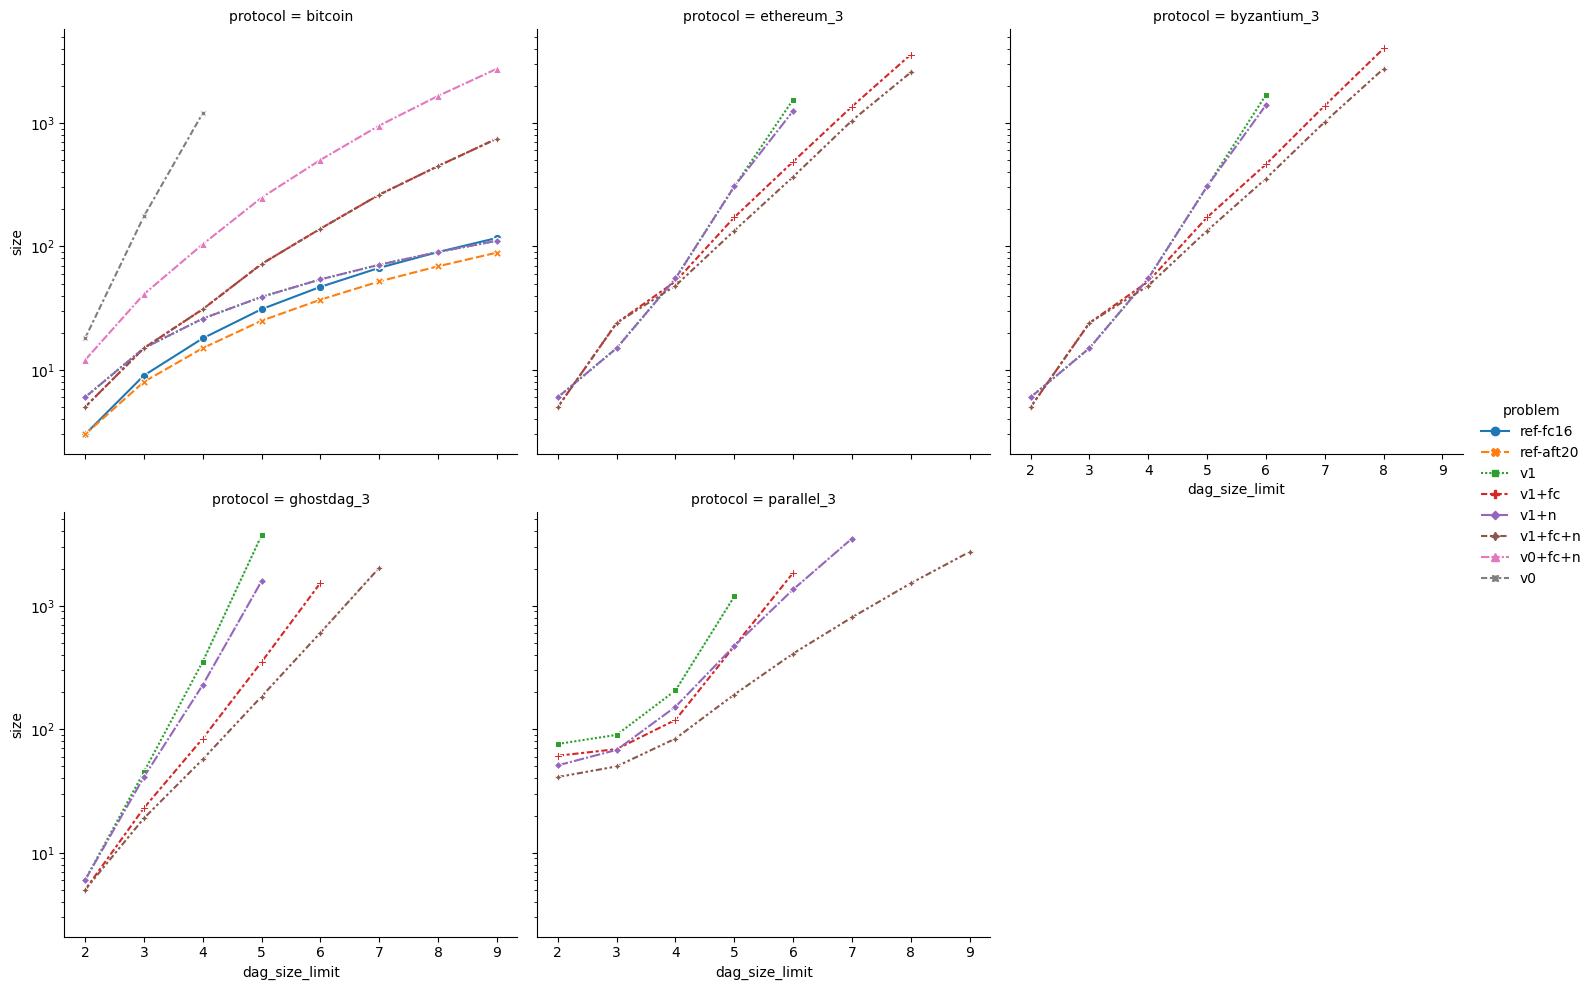

In [8]:
seaborn.relplot(
    data=size_log.query("dag_size_limit < 10"),
    kind="line",
    x="dag_size_limit",
    y="size",
    hue="problem",
    style="problem",
    markers=True,
    col="protocol",
    col_wrap=3,
).set(yscale="log")